# Catchment Classification

In [1]:
import itertools
from collections import defaultdict
from pathlib import Path

import cytoolz.curried as tlz
import numpy as np
import pandas as pd

import hydrosignatures as hsg
import pygeohydro as hgh
import pynhd
import pynldas2 as nldas
from pynhd import NLDI, StreamCat

In this tutorial, we use HyRiver libraries to classify catchments based on their hydrological characteristics from drought propagation mechanisms prospective. We follow [Apurv et al., (2017)](http://dx.doi.org/10.1002/2017WR021445). They classify catchments into three types as shown in the figure below.

<img src="_static/drought.png" alt="Traditional Approach" style="width: 500px;"/>

In this figure $P$ is precipitation, $E_p$ is potential evapotranspiration.

We follow a similar approach, however instead of using physical modeling, we employ a machine learning algorithm. Moreover, we carry out our analysis for the 531 USGS stations that was used in [Newman et al. (2017)](https://doi.org/10.1175/JHM-D-16-0284.1) (a subset of CAMELS). However, instead of using the limited catchment attributes available in the CAMELS dataset, we use [StreamCat](https://www.epa.gov/national-aquatic-resource-surveys/streamcat-dataset) that includes over 600 attributes.

We use `pygeohydro.get_camels` function to get the entire CAMELS dataset and then use its `Newman_2017` variable to get our stations of interest.

In [2]:
basins, qobs = hgh.get_camels()

Note that both `basins` and `qobs` include all catchment attributes of CAMELS, the only difference is that `basins` has geometries of the stations' drainage area, and `qobs` has streamflow observations. For the purpose of this tutorial, we only need the location of stations and their IDs.

In [3]:
stations = basins.loc[basins["Newman_2017"], ["gauge_lon", "gauge_lat"]]

For the purpose of this tutorial, we compute three climate indices: aridity, phase, and seasonality.
Thus, we need to retrieve precipitation and potential evapotranspiration time series. We use [PyNLDAS2](https://docs.hyriver.io/readme/pynldas2.html). Note that NLDAS2 has a spatial resolution of 0.125 degree, so drainage area of most of our stations, are probably going to be within few pixels. Therefore, it's not really necessary to get gridded data for each station watershed and a single pixel, would be enough. Although, using 20 or 30 years of climate data works better, we use only 10 years (2000-2010) so the notebook runs faster. Feel free to increase the time period.

Since we are getting 10 years of hourly climate data for 531 stations, it's going to be memory intensive, and of course, time-consuming. Considering that we only need the aridity, phase, and seasonality index values, and not the actual climate data, it's more efficient to retrieve stations' climate data in chunks, compute the indices, and store them.

We compute the aridity index using [Budyko, 1974](https://www.cambridge.org/core/journals/quaternary-research/article/abs/climate-and-life-m-i-budyko-david-h-miller-translator-academic-press-new-york-3500/41572608FC33C2AA6EFD4D0AF96AF927), the phase index using a simple Spearman correlation coefficient between mean monthly summaries of $P$ and $E_p$, and seasonality index using [Walsh and Lawler, 1981](https://doi.org/10.1002/j.1477-8696.1981.tb05400.x) method.

If mean monthly correlation is positive, we assume in-phase, otherwise out-of-phase. Although, technically, the threshold for in-phase is 0.3, for out-of-phase -0.3, and in-between no-phase, we use 0.0 as the threshold for simplicity and, more importantly, matching the table from [Apurv et al., (2017)](http://dx.doi.org/10.1002/2017WR021445). They used a bit more complex method that detects in/out of phase and there's no no-phase.

For precipitation seasonality index, the threshold is 0.6, based on the following table from [Walsh and Lawler, 1981](https://doi.org/10.1002/j.1477-8696.1981.tb05400.x).

<img src="_static/si_table.png" alt="Traditional Approach" style="width: 500px;"/>

For aridity index, we want to use [UNEP](https://wedocs.unep.org/20.500.11822/30300)'s classification table which has a threshold of 0.65 for arid/humid classification. However, `hydrosignatures.compute_ai` computes the inverse of UNEP's definition which is common in the hydrology literature. So, we need to invert the index before using it.

<img src="_static/ai_table.png" alt="Traditional Approach" style="width: 380px;"/>

Note that the first time you run the following cell, it's going to take a while and might fail due to service issues, since we are requesting for large amount of data. However, if failed you can rerun, and it should work. After the first time running the cell successfully, if you run it again, since the NLDAS service calls have been cached, the cell should run in just a few minutes.

In [4]:
sig_paath = Path("cache/signatures.parquet")
if sig_paath.exists():
    sig = pd.read_parquet(sig_paath)
else:
    sig = defaultdict(dict)
    station_its = zip(stations.index, zip(stations["gauge_lon"], stations["gauge_lat"]))
    for coord_ids in tlz.partition_all(50, station_its):
        sid, coords = zip(*coord_ids)
        clm = nldas.get_bycoords(coords, "2000-01-01", "2010-01-01", sid, variables=["prcp", "pet"])

        mean_monthly = hsg.compute_mean_monthly(clm, index_abbr=True)
        corr = mean_monthly.corr("spearman").xs("pet", level=1, axis=1).xs("prcp", level=1, axis=0)
        sig["phase"].update(dict(zip(corr.index, np.diag(corr) > 0)))  # if in-phase

        ai = hsg.compute_ai(clm.xs("pet", level=1, axis=1), clm.xs("prcp", level=1, axis=1))
        sig["aridity"].update((1 / ai > 0.65).to_dict())  # if humid

        si = hsg.compute_si_walsh(clm.xs("prcp", level=1, axis=1))
        sig["seasonality"].update((si > 0.6).to_dict())  # if seasonal
    sig = pd.DataFrame(sig)
    sig.index.name = "station_id"
    sig.to_parquet("cache/signatures.parquet")
sig.head()

,phase,aridity,seasonality,type
station_id,,,,
01022500,False,True,False,type1
01031500,True,True,False,type3
01047000,True,True,False,type3
01052500,True,True,False,type3
01054200,True,True,False,type3


Now, we need to determine the type of each station based on the table.

In [5]:
def get_class(inphase: bool, humid: bool, seasonal: bool) -> str:
    if not inphase:
        return "type1"
    if inphase and not humid:
        return "type2"
    if inphase and humid and not seasonal:
        return "type3"
    return "type1"


sig_itr = sig[["phase", "aridity", "seasonality"]].itertuples(index=False, name=None)
sig["type"] = list(itertools.starmap(get_class, sig_itr))
sig.head()

,phase,aridity,seasonality,type
station_id,,,,
01022500,False,True,False,type1
01031500,True,True,False,type3
01047000,True,True,False,type3
01052500,True,True,False,type3
01054200,True,True,False,type3


Next, we need to get watersheds' characteristics. For this purpose, first we find their associated NHDPlus ComID using `pynhd.NLDI`.

In [6]:
nldi = NLDI()
comids = nldi.getfeature_byid("nwissite", [f"USGS-{i}" for i in stations.index])

StreamCat contains around 600 characteristics from a variety of sources. Since, we are interested in physical characteristics of these watersheds, first we need to filter out those characteristics that are not related. To do so, we use `StreamCat.metrics_df`. Note that, in PyNHD, the main function for querying StreamCat is `streamcat`. There is also a class called `StreamCat` that contains useful information about the dataset such as available options for characteristic (called metrics in StreamCat), their descriptions, and so on. So, it's always a good idea to start with instantiating this class and figure out the available options.

In [7]:
sc = StreamCat()
sc.metrics_df.head()

,AOI,DATE_DOWNLOADED,FINAL_TABLE,INDICATOR_CATEGORY,METADATA,METRIC_DESCRIPTION,METRIC_NAME,METRIC_UNITS,SOURCE_NAME,SOURCE_URL,UUID,YEAR,SLOPE
0,"Cat, Ws",02-13-2016,Dams,Anthropogenic,https://edg.epa.gov/metadata/rest/document?id=...,Total possible volume of all reservoirs (NID_S...,DamNIDStor,cubic meters/square kilometer,USGS NAWQA,ftp://ftpext.usgs.gov/pub/er/va/reston/NAWQA_E...,46EB14C8-FC84-4BA8-9C7F-CC4938FD1FF3,NaN,NaN
1,"Cat, Ws",02-13-2016,Dams,Anthropogenic,https://edg.epa.gov/metadata/rest/document?id=...,Normal (most common) volume of all reservoirs ...,DamNrmStor,cubic meters/square kilometer,USGS NAWQA,ftp://ftpext.usgs.gov/pub/er/va/reston/NAWQA_E...,46EB14C8-FC84-4BA8-9C7F-CC4938FD1FF3,NaN,NaN
2,"Cat, Ws",NaN,Elevation,Natural,https://edg.epa.gov/metadata/rest/document?id=...,Mean AOI elevation in meters.,Elev,Meters,NHDPlusV2,http://www.horizon-systems.com/NHDPlus/NHDPlus...,1730F0BC-7019-4821-8B31-4A6E7B3DA625,NaN,NaN
3,"Cat, Ws",04-16-2015,GeoChemPhys1,Natural,https://edg.epa.gov/metadata/rest/document?id=...,Mean % of lithological ferric oxide (Fe2O3) co...,Fe2O3,Percent,USGS Sciencebase,https://www.sciencebase.gov/catalog/folder/534...,46EB14C8-FC84-4BA8-9C7F-CC4938FD1FF3,NaN,NaN
4,"Cat, Ws",03-17-2016,AgriculturalNitrogen,Anthropogenic,https://edg.epa.gov/metadata/rest/document?id=...,Mean rate of synthetic nitrogen fertilizer app...,Fert,mean rate kilogram Nitrogen/hectare/year,EnviroAtlas,https://enviroatlas.epa.gov/enviroatlas/DataFa...,46EB14C8-FC84-4BA8-9C7F-CC4938FD1FF3,NaN,NaN


We narrow down the list of metrics, by first looking at `FINAL_TABLE` column of the metrics' dataframe.

By going over these options, we select those that are related to physical characteristics of the catchments.

In [8]:
sc.metrics_df[sc.metrics_df.METRIC_DESCRIPTION.str.contains("index", case=False)]

,AOI,DATE_DOWNLOADED,FINAL_TABLE,INDICATOR_CATEGORY,METADATA,METRIC_DESCRIPTION,METRIC_NAME,METRIC_UNITS,SOURCE_NAME,SOURCE_URL,UUID,YEAR,SLOPE
7,"Cat, Ws",04-01-2016,Kffact,Natural,https://edg.epa.gov/metadata/rest/document?id=...,Mean soil erodibility (Kf) factor (unitless) o...,AgKffact,mean surface soil erodibility factors,Penn State Soil Info,http://www.soilinfo.psu.edu/index.cgi?soil_dat...,EBB945ED-0151-4DBF-8FE0-806165A58973,NaN,NaN
9,"Cat, Ws",03-10-2015,BFI,Natural,https://edg.epa.gov/metadata/rest/document?id=...,Baseflow is the component of streamflow that c...,BFI,Percent,USGS Water Mission Area,http://water.usgs.gov/GIS/metadata/usgswrd/XML...,66C0ED41-2707-4732-A906-E9D89E8F5A6B,NaN,NaN
35,Other,09-04-2017,NRSA_PredictedBioCondition,Natural,https://edg.epa.gov/metadata/rest/document?id=...,Predicted probability that a stream segment is...,prG_BMMI[Year],Percent,Hill et al. 2017,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,E4DB0FCC-4CB4-43CD-BE0B-C82858D85D36,"2008, 2009",NaN
46,"Cat, Ws",06-14-2016,Kffact,Natural,https://edg.epa.gov/metadata/rest/document?id=...,Mean soil erodibility (Kf) factor (unitless) o...,Kffact,index value,Penn State Soil Info,http://www.soilinfo.psu.edu/index.cgi?soil_dat...,AA3ADCFD-0758-47FC-A069-31E95A116A3D,NaN,NaN
116,"Cat, Ws",10-01-2018,WetIndex,Natural,https://edg.epa.gov/metadata/rest/document?id=...,Mean Composite Topographic Index (CTI) [Wetnes...,WetIndex,Avg. rate (mm),EnviroAtlas,http://enviroatlas.epa.gov/enviroatlas/datafac...,E4DB0FCC-4CB4-43CD-BE0B-C82858D85D36,NaN,NaN


In [9]:
themes = (
    "Dams",
    "Elevation",
    "Kffact",
    "BFI",
    "STATSGO_Set1",
    "NLCD",
    "STATSGO_Set2",
    "PRISM_0809",
    "Runoff",
    "Precip_Minus_EVT",
    "WetIndex",
)
metrics = sc.metrics_df[sc.metrics_df.FINAL_TABLE.isin(themes)]
metrics.head()

,AOI,DATE_DOWNLOADED,FINAL_TABLE,INDICATOR_CATEGORY,METADATA,METRIC_DESCRIPTION,METRIC_NAME,METRIC_UNITS,SOURCE_NAME,SOURCE_URL,UUID,YEAR,SLOPE
0,"Cat, Ws",02-13-2016,Dams,Anthropogenic,https://edg.epa.gov/metadata/rest/document?id=...,Total possible volume of all reservoirs (NID_S...,DamNIDStor,cubic meters/square kilometer,USGS NAWQA,ftp://ftpext.usgs.gov/pub/er/va/reston/NAWQA_E...,46EB14C8-FC84-4BA8-9C7F-CC4938FD1FF3,NaN,NaN
1,"Cat, Ws",02-13-2016,Dams,Anthropogenic,https://edg.epa.gov/metadata/rest/document?id=...,Normal (most common) volume of all reservoirs ...,DamNrmStor,cubic meters/square kilometer,USGS NAWQA,ftp://ftpext.usgs.gov/pub/er/va/reston/NAWQA_E...,46EB14C8-FC84-4BA8-9C7F-CC4938FD1FF3,NaN,NaN
2,"Cat, Ws",NaN,Elevation,Natural,https://edg.epa.gov/metadata/rest/document?id=...,Mean AOI elevation in meters.,Elev,Meters,NHDPlusV2,http://www.horizon-systems.com/NHDPlus/NHDPlus...,1730F0BC-7019-4821-8B31-4A6E7B3DA625,NaN,NaN
7,"Cat, Ws",04-01-2016,Kffact,Natural,https://edg.epa.gov/metadata/rest/document?id=...,Mean soil erodibility (Kf) factor (unitless) o...,AgKffact,mean surface soil erodibility factors,Penn State Soil Info,http://www.soilinfo.psu.edu/index.cgi?soil_dat...,EBB945ED-0151-4DBF-8FE0-806165A58973,NaN,NaN
9,"Cat, Ws",03-10-2015,BFI,Natural,https://edg.epa.gov/metadata/rest/document?id=...,Baseflow is the component of streamflow that c...,BFI,Percent,USGS Water Mission Area,http://water.usgs.gov/GIS/metadata/usgswrd/XML...,66C0ED41-2707-4732-A906-E9D89E8F5A6B,NaN,NaN


By looking at these metrics, we realize that some metrics are annual summaries and require specifying the year. We can use `StreamCat.valid_years` to check the available years. For example, let's get the last year of the available years for each metric. Note that, we need to replace `[Year]` in `METRIC_NAME` column of `metrics_df`.

Now, we use these metrics and ComIDs to obtain their characteristics.

In [10]:
names = metrics[metrics.YEAR.isna()].METRIC_NAME.to_list()
names_yr = metrics[~metrics.YEAR.isna()].METRIC_NAME
names += [n.replace("[Year]", str(sc.valid_years[n][-1])) for n in names_yr]

Now, to facilitate cross walking between the catchment attributes and climate indices datasets, we change the index of ``attrs`` dataframe to be the station ID, and append the catchment types to the dataframe.

In [11]:
attrs = pynhd.streamcat(names, comids=comids.comid, metric_areas="watershed")
attrs = attrs.dropna(axis=1)
attrs.columns = attrs.columns.str.lower()
attrs.head()

,comid,wsareasqkm,clayws,sandws,elevws,wetindexws,runoffws,tmean09ws,precip09ws,precip_minus_evtws,...,pcturbmd2019ws,pcthbwet2019ws,pctconif2019ws,pcturbop2019ws,pctshrb2019ws,pctcrop2019ws,pcthay2019ws,pctmxfst2019ws,pctgrs2019ws,pcturbhi2019ws
0,272589,488.3202,5.699805,81.573543,239.6469,966.4871,362.4216,4.454809,753.066947,23.1532,...,0.03,1.80,10.52,4.31,1.16,0.0,0.05,13.05,0.84,0.00
1,399452,38.6820,37.971573,21.478252,405.2075,783.9151,376.5604,13.602834,1175.682583,26.0265,...,0.87,0.00,0.02,5.14,2.85,0.0,59.54,0.46,2.70,0.43
2,400496,808.0020,34.487492,24.813596,346.2187,746.4028,379.1795,14.033619,1476.165119,32.1875,...,0.28,0.08,0.73,4.24,1.89,0.0,37.90,4.28,1.82,0.11
3,400822,106.6815,29.019383,33.615368,407.6582,755.9538,378.7824,13.712378,1502.645026,32.5037,...,0.41,0.00,0.31,4.00,0.92,0.0,42.16,3.43,0.90,0.15
4,487460,158.6061,21.920000,23.720000,469.7755,580.5784,519.3887,12.217670,1512.615391,45.3002,...,0.21,0.00,0.04,3.73,4.20,0.0,0.38,7.37,2.13,0.02


<Axes: >

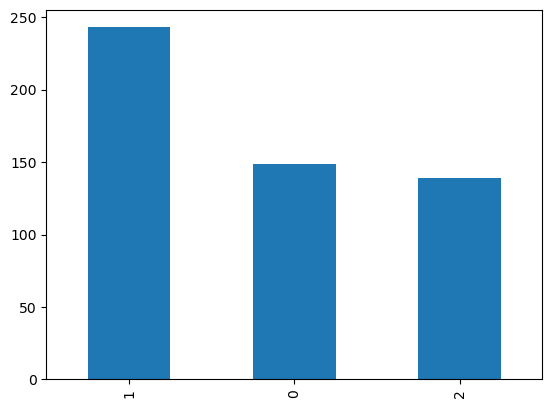

In [13]:
sid_comid = comids[["identifier", "comid"]].copy()
sid_comid["identifier"] = sid_comid["identifier"].str.replace("USGS-", "")
sid_comid["comid"] = sid_comid["comid"].astype(int)
attrs = attrs.merge(sid_comid, left_on="comid", right_on="comid")
attrs = attrs.set_index("identifier")
attrs.index.name = "station_id"
attrs["type"] = sig["type"]
attrs = attrs.drop("comid", axis=1)
attrs.head()
type_mapping = {"type1": 0, "type2": 1, "type3": 2}
attrs["type"] = attrs["type"].map(type_mapping).astype(int)
attrs["type"].value_counts().plot.bar()

In [14]:
conus = pynhd.streamcat(names, conus=True, metric_areas="watershed")
conus = conus.dropna(axis=1, how="all")
conus = conus.dropna(axis=0)
conus.columns = conus.columns.str.lower()
conus.head()

,comid,wsareasqkm,clayws,sandws,elevws,wetindexws,kffactws,agkffactws,runoffws,tmean09ws,...,pcturbmd2019ws,pcthbwet2019ws,pctconif2019ws,pcturbop2019ws,pctshrb2019ws,pctcrop2019ws,pcthay2019ws,pctmxfst2019ws,pctgrs2019ws,pcturbhi2019ws
0,23796953,37.4472,36.008147,13.272119,150.9796,731.3332,0.3098,0.1078,1189.0,10.946465,...,0.30,0.39,14.17,2.65,3.60,12.06,33.03,23.93,0.93,0.04
1,23797225,6.2469,40.545943,15.330458,421.2429,681.2311,0.2559,0.0000,1189.0,10.275770,...,0.00,0.00,70.47,4.37,1.05,0.00,0.04,17.42,5.36,0.00
2,23797735,7.4619,21.825341,27.091912,462.4695,570.2685,0.2507,0.0000,1189.0,9.841584,...,0.02,0.00,75.07,6.27,1.30,0.00,0.00,10.73,6.43,0.00
3,23797721,0.4617,20.324308,28.433392,867.2295,568.2242,0.2406,0.0000,1189.0,9.772891,...,0.00,0.00,84.99,9.36,0.00,0.00,0.00,0.00,5.65,0.00
4,23801020,23.5935,19.553445,27.926475,780.2219,646.2592,0.2440,0.0000,1406.0,7.964721,...,0.00,0.00,92.06,0.00,5.87,0.00,0.00,0.26,1.51,0.00
